In this project we will use Machine Learning to predict if the price of a stock is positive or negativ in the future. We will not predict the actual price of a stock, if there price is higher or lower in a certain number of days. Hereby we use the Randomforest Classifier and use technical analysis data for the Randomforest Classifier to train on. at the end we will test our strategy on a different stock or on future data.

In [1]:
#First we will need all the basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from datetime import datetime
import math 
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [2]:
#First we can set dates to download historical data for certain companys
start = "2018-01-01"
end = "2020-01-01"
#optional if we want the end date to be today 
#end = datetime.today().strftime("%Y-%m-%d")

In [3]:
assets =["FB", "AMZN", "AAPL", "NFLX", "GOOG"]

In [4]:
#creating for each company a dataframe 
#you might have to run the for loop above sometimes because some companys might have no historical data therefore
#the data cant be used
for asset in assets:
    exec('{} = web.DataReader(asset, data_source = "yahoo", start= start, end = end)'.format(asset))

In [5]:
asset_list = [FB, AMZN, AAPL, NFLX, GOOG]

Since we have all the historical data and dataframes in a list we can write a function to calculate 5 technical indicators which whill be used for the model to learn

In [6]:
#function to calculate all the technical indicators RSI Stochastic Oscillator Williams %R MACD ROC
def indikator(asset):
    n = 14
    #Calculating RSI
    delta = asset["Adj Close"].diff(1)
    delta.dropna(inplace = True)
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    AVG_Gain = up.rolling(window=n).mean()
    AVG_Loss = abs(down.rolling(window=n).mean())
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 -(100.0/(1.0 +RS))
    asset["up"]=up
    asset["down"]=down
    asset["RSI"]=RSI
    
    #Stochastic Oscillator
    low_14, high_14 = asset["Low"].copy(), asset["High"].copy()
    low_14 = low_14.transform(lambda x: x.rolling(window = n).min())
    high_14 = high_14.transform(lambda x: x.rolling(window = n).max())
    k_percent = 100 * ((asset["Close"] - low_14) / (high_14 - low_14))
    asset["k_percent"] = k_percent
    asset["d_percent"] = k_percent.rolling(window = 3).mean()
    asset['high_14'] = high_14
    asset['low_14'] = low_14
    
    #Williams R%
    low_14, high_14 = asset["Low"].copy(), asset["High"].copy()
    low_14 = low_14.transform(lambda x: x.rolling(window = n).min())
    high_14 = high_14.transform(lambda x: x.rolling(window = n).max())
    r_percent = ((high_14 - asset['Close']) / (high_14 - low_14)) * - 100
    asset['r_percent'] = r_percent
    
    #MACD
    ema_26 = asset['Adj Close'].ewm(span=26, adjust = False).mean()
    ema_12 = asset['Adj Close'].ewm(span=12, adjust = False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span = 9, adjust= False).mean()
    asset['MACD'] = macd
    asset['MACD_EMA'] = signal
    
    #ROC Price rate of change
    n_roc = 12
    M = asset["Adj Close"].diff(n_roc - 1)  
    N = asset["Adj Close"].shift(n_roc - 1)  
    ROC = ((M / N) * 100) +100
    asset['ROC'] = ROC
    
    #Prediction column, if price is higher in future = 1, else -1 and stayed the same = 0
    n_pred = 5
    asset.loc[asset["Adj Close"].shift(n_pred) == asset["Adj Close"], "Prediction"] = 0
    asset.loc[asset["Adj Close"].shift(n_pred) <= asset["Adj Close"], "Prediction"] = -1
    asset.loc[asset["Adj Close"].shift(n_pred) >= asset["Adj Close"], "Prediction"] = 1

In [9]:
for asset in asset_list:
    indikator(asset)

In [10]:
FB.head(7)

,High,Low,Open,Close,Volume,Adj Close,up,down,RSI,k_percent,d_percent,high_14,low_14,r_percent,MACD,MACD_EMA,ROC,Prediction
Date,,,,,,,,,,,,,,,,,,
2018-01-02,181.580002,177.550003,177.679993,181.419998,18151900,181.419998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
2018-01-03,184.779999,181.330002,181.880005,184.669998,16886600,184.669998,3.250000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.259259,0.051852,NaN,NaN
2018-01-04,186.210007,184.100006,184.899994,184.330002,13880900,184.330002,0.000000,-0.339996,NaN,NaN,NaN,NaN,NaN,NaN,0.432306,0.127943,NaN,NaN
2018-01-05,186.899994,184.929993,185.589996,186.850006,13574500,186.850006,2.520004,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.763983,0.255151,NaN,NaN
2018-01-08,188.899994,186.330002,187.199997,188.279999,17994700,188.279999,1.429993,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.129211,0.429963,NaN,NaN
2018-01-09,188.800003,187.100006,188.699997,187.869995,12393100,187.869995,0.000000,-0.410004,NaN,NaN,NaN,NaN,NaN,NaN,1.369783,0.617927,NaN,-1.0
2018-01-10,187.889999,185.630005,186.940002,187.839996,10529900,187.839996,0.000000,-0.029999,NaN,NaN,NaN,NaN,NaN,NaN,1.540263,0.802394,NaN,-1.0


In [12]:
#Putting all the data into one dataframe to use it for the ML Algorithm
#same as above I havent found a better way to do it but hopefully someday I will 
df = FB.append((AMZN, AAPL, NFLX, GOOG))
# Deleting all the NaN values 
df.dropna(inplace=True)
# Showing the shape of our final dataframe
df.shape

(2440, 18)

Now that we finally have our finished dataframe with all the companys and their technical indicator values and a Prediction column we can split them into X and Y columns and train our model

In [13]:
# Grab our X & Y Columns.
X_Cols = df[['RSI','k_percent','r_percent','ROC','MACD']]
Y_Cols = df['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0, train_size= 0.95, test_size = 0.05)

In [14]:
# Create a Random Forest Classifier
model = RandomForestClassifier(n_estimators = 1000, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [15]:
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  81.14754098360656


Now we have a trained model with an accuracy of 81% which is not that bad. We can test our model now on a different stock from the technology sector such as the FAANG compnays and see how our model predicts future outcomes based on their technical indicators

In [16]:
#For example we use NVDA now and let the model predict on NVDA technical indicators
NVDA = web.DataReader("NVDA", data_source = "yahoo", start= start, end = end)
indikator(NVDA)
NVDA.dropna(inplace = True)

In [17]:
NVDA["predicted"] = model.predict(NVDA[["RSI","k_percent","r_percent","ROC","MACD"]])

In [18]:
NVDA.head(7)

,High,Low,Open,Close,Volume,Adj Close,up,down,RSI,k_percent,d_percent,high_14,low_14,r_percent,MACD,MACD_EMA,ROC,Prediction,predicted
Date,,,,,,,,,,,,,,,,,,,
2018-01-24,240.490005,233.550003,239.039993,235.800003,14499300.0,233.843262,0.000000,-3.084183,80.560702,84.053037,93.774958,240.490005,211.080002,-15.946963,8.511366,6.822627,106.216225,-1.0,-1.0
2018-01-25,239.750000,235.750000,238.000000,236.350006,10247100.0,234.388672,0.545410,0.000000,80.266006,85.923159,89.142104,240.490005,211.080002,-14.076841,8.656356,7.189373,106.492746,-1.0,-1.0
2018-01-26,243.339996,237.600006,238.119995,243.330002,12908900.0,241.310776,6.922104,0.000000,82.651446,99.963444,89.979880,243.339996,216.000000,-0.036556,9.223495,7.596197,108.784879,-1.0,-1.0
2018-01-29,248.110001,240.610001,242.740005,246.850006,11377900.0,244.801559,3.490784,0.000000,81.305165,96.076006,93.987536,248.110001,216.000000,-3.923994,9.841191,8.045196,110.161538,-1.0,-1.0
2018-01-30,246.419998,238.410004,241.110001,242.720001,14270800.0,240.705811,0.000000,-4.095749,73.743159,83.213954,93.084468,248.110001,216.000000,-16.786046,9.886264,8.413410,108.852811,-1.0,-1.0
2018-01-31,249.270004,244.449997,245.770004,245.800003,11964400.0,243.760269,3.054459,0.000000,74.523301,89.349291,89.546417,249.270004,216.690002,-10.650709,10.052574,8.741242,111.671417,-1.0,-1.0
2018-02-01,246.899994,238.059998,238.520004,240.500000,12980600.0,238.504257,0.000000,-5.256012,66.420001,73.081634,81.881626,249.270004,216.690002,-26.918366,9.649032,8.922800,107.022077,-1.0,1.0


Creating a function to get Buy and Sell Signals based on the models prediction to trade on

In [21]:
def buy_sell(data):
    sigPriceBuy=[]
    sigPriceSell=[]
    flag = -1 
    counter = 0
    n= 5
    
    for i in range(len(data)):
        if data["predicted"][i] == 1 and counter == 0:
            if flag != 1:
                sigPriceBuy.append(data["Adj Close"][i])
                sigPriceSell.append(np.nan)
                flag = 1 
                
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif data["predicted"][i] == -1 and counter == 0:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data["Adj Close"][i])
                flag = 0
            else: 
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
        
        counter +=1 
        if counter == n:
            counter = 0
        
    return (sigPriceBuy, sigPriceSell)

In [22]:
buysell = buy_sell(NVDA)
NVDA["Buy"] = buysell[0]
NVDA["Sell"] = buysell[1]

In [35]:
NVDA.head(7)

,High,Low,Open,Close,Volume,Adj Close,up,down,RSI,k_percent,...,high_14,low_14,r_percent,MACD,MACD_EMA,ROC,Prediction,predicted,Buy,Sell
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-24,240.490005,233.550003,239.039993,235.800003,14499300.0,233.843262,0.000000,-3.084183,80.560702,84.053037,...,240.490005,211.080002,-15.946963,8.511366,6.822627,106.216225,-1.0,-1.0,NaN,NaN
2018-01-25,239.750000,235.750000,238.000000,236.350006,10247100.0,234.388672,0.545410,0.000000,80.266006,85.923159,...,240.490005,211.080002,-14.076841,8.656356,7.189373,106.492746,-1.0,-1.0,NaN,NaN
2018-01-26,243.339996,237.600006,238.119995,243.330002,12908900.0,241.310776,6.922104,0.000000,82.651446,99.963444,...,243.339996,216.000000,-0.036556,9.223495,7.596197,108.784879,-1.0,-1.0,NaN,NaN
2018-01-29,248.110001,240.610001,242.740005,246.850006,11377900.0,244.801559,3.490784,0.000000,81.305165,96.076006,...,248.110001,216.000000,-3.923994,9.841191,8.045196,110.161538,-1.0,-1.0,NaN,NaN
2018-01-30,246.419998,238.410004,241.110001,242.720001,14270800.0,240.705811,0.000000,-4.095749,73.743159,83.213954,...,248.110001,216.000000,-16.786046,9.886264,8.413410,108.852811,-1.0,-1.0,NaN,NaN
2018-01-31,249.270004,244.449997,245.770004,245.800003,11964400.0,243.760269,3.054459,0.000000,74.523301,89.349291,...,249.270004,216.690002,-10.650709,10.052574,8.741242,111.671417,-1.0,-1.0,NaN,NaN
2018-02-01,246.899994,238.059998,238.520004,240.500000,12980600.0,238.504257,0.000000,-5.256012,66.420001,73.081634,...,249.270004,216.690002,-26.918366,9.649032,8.922800,107.022077,-1.0,1.0,NaN,NaN


In [29]:
#Since we want our first action is to buy a stock we need to remove the Sell Signal at the start
NVDA["Sell"][0] = np.nan

Now we can plot our Buy and Sell Signals

<function matplotlib.pyplot.show>

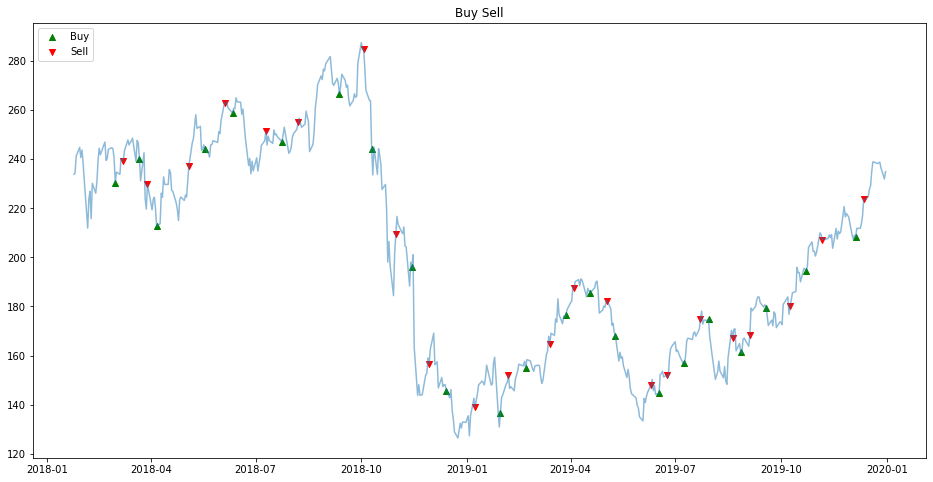

In [31]:
plt.figure(figsize=(16,8))
plt.scatter(NVDA.index, NVDA["Buy"], color = "green", label = "Buy", marker ="^", alpha=1)
plt.scatter(NVDA.index, NVDA["Sell"], color = "red", label = "Sell", marker ="v", alpha=1)
plt.plot(NVDA.index, NVDA["Adj Close"], alpha=0.5)
plt.title("Buy Sell")
plt.legend(loc= "upper left")
plt.show

Now we create a function to test the performance of our ML trading strategy and give it a start capital of like 1000000 or something like that and always buy the maximum amount of stocks we can get with the capital and sell them as soon as a sell signal appears

In [40]:
def performance(dataframe):
    performance = [1000000]
    num_stocks = 0
    for i in range(len(dataframe)):
        if math.isnan(dataframe["Buy"][i]) != True:
            num_stocks = performance[i]/dataframe["Adj Close"][i]
            performance.append(num_stocks*dataframe["Adj Close"][i])
        elif math.isnan(dataframe["Sell"][i]) != True:
            cash = num_stocks * dataframe["Adj Close"][i]
            performance.append(cash)
        else: 
            performance.append(performance[i])
            
    return performance

In [41]:
NVDA_performance = performance(NVDA)

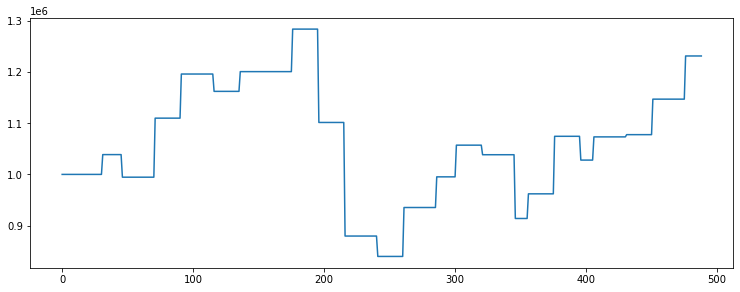

In [42]:
#Plot and see how our strategy performed during 
plt.figure(figsize= (12.6, 4.6))
plt.plot(NVDA_performance)